In [42]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [43]:
# import math lib
from math import pi

# import Qiskit
from qiskit import Aer, IBMQ, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [44]:
# To use local qasm simulator
backend = Aer.get_backend('qasm_simulator')

In [45]:
def get_theta(d):
    x = d[0]
    y = d[1]
    
    theta = 2*math.acos((x+y)/2.0)
    return theta

In [46]:
def get_Distance(x,y):
    theta_1 = get_theta(x)
    theta_2 = get_theta(y)
    
    # create Quantum Register called "qr" with 3 qubits
    qr = QuantumRegister(3, name="qr")
    # create Classical Register called "cr" with 5 bits
    cr = ClassicalRegister(3, name="cr")

    # Creating Quantum Circuit called "qc" involving your Quantum Register "qr"
    # and your Classical Register "cr"
    qc = QuantumCircuit(qr, cr, name="k_means")
    
    qc.h(qr[0])
    qc.h(qr[1])
    qc.h(qr[2])
    qc.u3(theta_1, pi, pi, qr[1])
    qc.u3(theta_2, pi, pi, qr[2])
    qc.cswap(qr[0], qr[1], qr[2])
    qc.h(qr[0])

    qc.measure(qr[0], cr[0])
    qc.reset(qr)

    #print('----before run----')
    job = execute(qc,backend=backend, shots=1024)
    #print('----after run----')
    result = job.result()
    #data = result.get_data()['counts']
    data = result.get_counts(qc)
    
    if len(data)==1:
        return 0.0
    else:
        return data['001']/1024.0
    
    

In [47]:
def get_data(n,k,std):
    data = make_blobs(n_samples=n, n_features=2, centers=k, cluster_std=std, random_state=100)
    points = data[0]
    centers = data[1]
    
    return points,centers

In [48]:
def draw_plot(points,centers,label=True):
    if label==False:
        plt.scatter(points[:,0], points[:,1])
    else:
        plt.scatter(points[:,0], points[:,1], c=centers, cmap='viridis')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()

In [49]:
def plot_centroids(centers):
    plt.scatter(centers[:,0], centers[:,1])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()

In [50]:
def initialize_centers(points,k):
    return points[np.random.randint(points.shape[0],size=k),:]

In [51]:
def get_distance(p1, p2):
    return np.sqrt(np.sum((p1-p2)*(p1-p2)))

In [52]:
def find_nearest_neighbour(points,centroids):
    
    n = len(points)
    k = centroids.shape[0]
    centers = np.zeros(n)
    
    for i in range(n):
        min_dis = 10000
        ind = 0
        for j in range(k):
            
            temp_dis = get_Distance(points[i,:],centroids[j,:])
            
            if temp_dis < min_dis:
                min_dis = temp_dis
                ind = j
        centers[i] = ind
    
    return centers

In [53]:
def find_centroids(points,centers):
    n = len(points)
    k = int(np.max(centers))+1
   
    centroids = np.zeros([k,2])
    
    for i in range(k):
        #print(points[centers==i])
        centroids[i,:] = np.average(points[centers==i])
        
    return centroids

In [54]:
def preprocess(points):
    n = len(points)
    x = 30.0*np.sqrt(2)
    for i in range(n):
        points[i,:]+=15
        points[i,:]/=x
    
    return points

In [55]:
import sklearn.datasets as datasets
## DATASET 1: IRIS FROM SKLEARN
# imported as dictionary {'data':, 'target':, 'target_names':}
iris_dataset = datasets.load_iris()
iris_data = np.array(iris_dataset['data'])
iris_target = np.array(iris_dataset['target'])

## DATASET 2: WINE FROM SKLEARN
wine_dataset = datasets.load_wine()
wine_data = np.array(wine_dataset['data'])
wine_target = np.array(wine_dataset['target'])

## DATASET 3: BREAST CANCER FROM SKLEARN
bcancer_dataset = datasets.load_breast_cancer()
bcancer_data = np.array(bcancer_dataset['data'])
bcancer_target = np.array(bcancer_dataset['target'])

In [56]:
from sklearn.datasets import make_blobs

def generate_fake_dataset(samples, features, centers, std):
    blobs, classes = make_blobs(n_samples=samples, n_features=features, centers=centers, cluster_std=std, random_state=100)
    return blobs, classes

In [57]:
def kmeans_quantum(samples, class_num):
    # choose 6 random samples to be the centroids
    samples = preprocess(samples)
    indices = np.random.randint(samples.shape[0], size=class_num)
    centroid_list = initialize_centers(samples,class_num)
    #print(centroid_list)
    
    #old_class = np.zeros(samples.shape[0])
    stop_flag = False
    old_centroid_list = centroid_list
    start_time = time.time()
    counter = 0
    print('old', old_centroid_list)
    
    # assign classes based on current centroids
    while not stop_flag:
        counter +=1
        print(counter)
        new_class = find_nearest_neighbour(samples, old_centroid_list)
        new_centroid_list = find_centroids(samples, new_class)
        print(np.array(old_centroid_list))
        print(np.array(new_centroid_list))
        #print(new_class)
        if np.sum(np.array(new_centroid_list-old_centroid_list)) == 0:
            stop_flag = True
            stop_time = time.time()
        else:
            print("else reached")
            old_centroid_list = new_centroid_list
            #old_class = new_class
    print("time taken: ", stop_time - start_time, " seconds")
    return samples, new_class, new_centroid_list

In [61]:
testx, testy = generate_fake_dataset(1000, 2, 5, 3)
points,o_centers = get_data(n,k,std)
a, b, c = kmeans_quantum(points, 5)

old [[0.44823689 0.42773491]
 [0.30924899 0.39883697]
 [0.41388296 0.49012149]
 [0.32310292 0.51741572]
 [0.38271297 0.2932502 ]]
1
[[0.44823689 0.42773491]
 [0.30924899 0.39883697]
 [0.41388296 0.49012149]
 [0.32310292 0.51741572]
 [0.38271297 0.2932502 ]]
[[0.44682726 0.44682726]
 [0.28495969 0.28495969]
 [0.49757645 0.49757645]
 [0.40418633 0.40418633]
 [0.2008531  0.2008531 ]]
else reached
2
[[0.44682726 0.44682726]
 [0.28495969 0.28495969]
 [0.49757645 0.49757645]
 [0.40418633 0.40418633]
 [0.2008531  0.2008531 ]]
[[0.446592   0.446592  ]
 [0.30634114 0.30634114]
 [0.5014087  0.5014087 ]
 [0.39452261 0.39452261]
 [0.14173125 0.14173125]]
else reached
3
[[0.446592   0.446592  ]
 [0.30634114 0.30634114]
 [0.5014087  0.5014087 ]
 [0.39452261 0.39452261]
 [0.14173125 0.14173125]]
[[0.45475918 0.45475918]
 [0.30219312 0.30219312]
 [0.49774794 0.49774794]
 [0.39003949 0.39003949]
 [0.13924725 0.13924725]]
else reached
4
[[0.45475918 0.45475918]
 [0.30219312 0.30219312]
 [0.49774794 0.49

KeyboardInterrupt: 

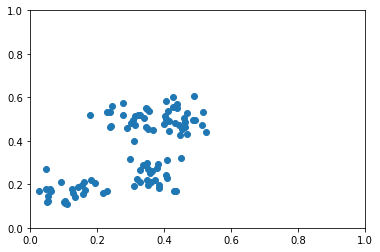

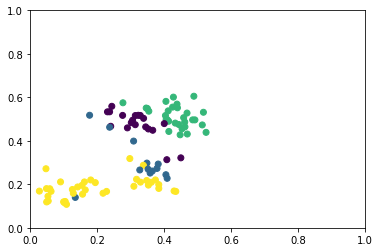

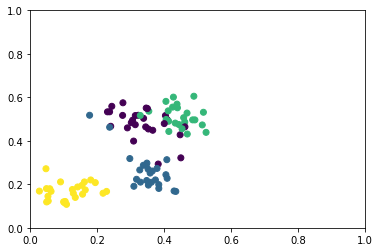

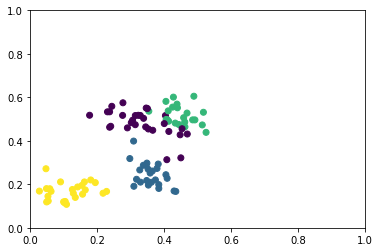

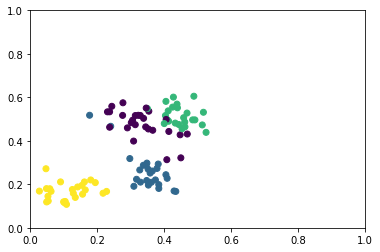

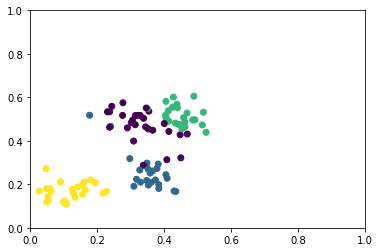

In [59]:
n = 100      # number of data points
k = 4        # Number of centers
std = 2      # std of datapoints

points,o_centers = get_data(n,k,std)       #dataset

points = preprocess(points)                # Normalize dataset
plt.figure()                                  
draw_plot(points,o_centers,label=False)

centroids = initialize_centers(points,k)   # Intialize centroids


# run k-means algorithm
for i in range(5):
    
    centers = find_nearest_neighbour(points,centroids)       # find nearest centers
    plt.figure()
    draw_plot(points,centers)
    #plot_centroids(centroids)
    centroids = find_centroids(points,centers)               # find centroids

0.171875